### 4. Pairwise replay and behavior

### (Use `TrialChoiceReplayTransition` and plot with behavior side by side.)
[This notebook uses TrialChoiceReplay().]
##### All the tables mentioned above are under shijiegu github/spyglass/shijiegu/Analysis_SGU.py. It is not in the Franklab spyglass.

Jun 30, 2024
Shijie Gu

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
import pynwb
import xarray as xr
import os
import pickle
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

In [3]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,TrialChoiceReplayTransition
from spyglass.shijiegu.helpers import interval_union,interpolate_to_new_time
from spyglass.shijiegu.load import load_LFP,load_position
from spyglass.shijiegu.ripple_detection import (loadRippleLFP,ExtendInterSection,InterSection,
                                                plot_ripple,threshold_by_zscore_Gu,
                                                Kay_ripple_detector,Karlsson_ripple_detector,Gu_ripple_detector,multiunit_HSE_detector,
                                                removeDataBeforeTrial1,removeArtifactTime,
                                                loadRippleLFP_OneChannelPerElectrode,ripple_detection_master)
from spyglass.shijiegu.Analysis_SGU import TetrodeNumber,MUA,ExtendedTrialChoiceReplay,ExtendedRippleTimes
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.common.common_task import TaskEpoch

[2024-11-27 16:59:20,661][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-11-27 16:59:20,703][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [4]:
from spyglass.shijiegu.pairwiseDecode import merge_overlapping_ranges,removeEmptyDecode
from spyglass.shijiegu.ripple_add_replay import remove_adjacent
from spyglass.shijiegu.pairwiseDecode import replay_transitions,categorized_replay_transitions,behavior_transitions,behavior_transitions_count,findXCorrAllDays
from spyglass.shijiegu.decodeHelpers import runSessionNames

### Specify which decoding model to use and days

In [110]:
animal = 'Eliot'
#dates_to_plot = ['20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']
encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'

In [79]:
animal = 'Lewis'
#dates_to_plot = ['20240106','20240107','20240108','20240109',
#                 '20240110','20240113','20240114','20240115','20240116','20240117','20240118','20240119','20240120']

dates_to_plot = ['20240106','20240107','20240108','20240109',
                 '20240110']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'

In [18]:
animal = 'Haydn'
dates_to_plot = ['20230604','20230605','20230606','20230607','20230608']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'

In [27]:
animal = 'Molly'
dates_to_plot = ['20220415','20220416','20220417','20220418','20220419','20220420']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'

### behavior only

In [37]:
animal = 'Lewis'
dates_to_plot = ['20240107','20240108','20240109','20240110','20240116','20240117','20240118','20240119','20240120','20240121']

In [6]:
animal = 'Haydn'
dates_to_plot = ['20230604','20230605','20230606','20230607']

In [7]:
P_behavior_all,xcorr_plot,xcorr25_plot,xcorr975_plot = behavior_transitions(animal,dates_to_plot)
C_behavior_all, C_behavior_reward_all = behavior_transitions_count(animal,dates_to_plot)

[Text(1, 0.1, '<0.2'),
 Text(1, 0.25, '0.25'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '>0.5')]

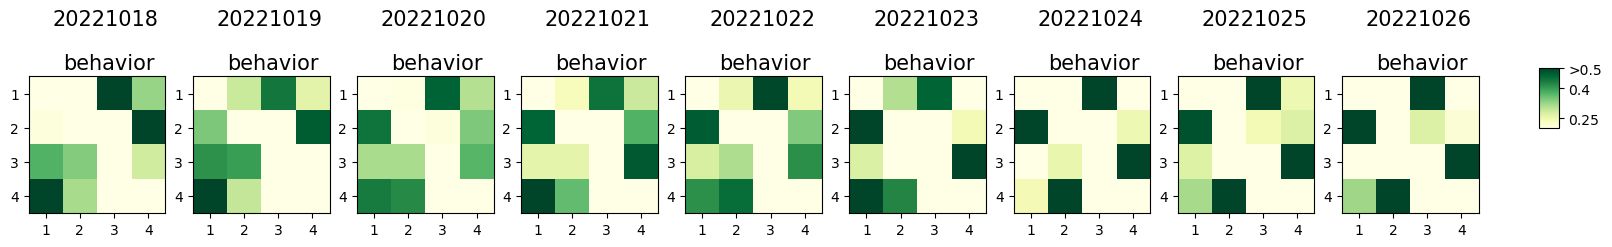

In [48]:
version = 1
fig,axes = plt.subplots(1,len(dates_to_plot),figsize = (20,3))

REPLAY_VMAX = 0.8
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = P_behavior_all[d]
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[d_ind].imshow(behavior_data, vmin = 0.2, vmax = 0.5, origin = 'upper',cmap = 'YlGn')

    
    # label arms
    axes[d_ind].set_xticks(np.arange(4))
    axes[d_ind].set_yticks(np.arange(4))
    axes[d_ind].set_xticklabels(['1','2','3','4'])
    axes[d_ind].set_yticklabels(['1','2','3','4'])

    axes[d_ind].text(0.2,-2,d,fontsize = 15)
    axes[d_ind].text(0.5,-0.7,'behavior',fontsize = 15)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, 0.5])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>0.5'])  # vertically oriented colorbar

### replay and behavior together

In [19]:
count, P_replay_all = replay_transitions(animal,dates_to_plot,encoding_set,classifier_param_name)
P_behavior_all,xcorr_plot,xcorr25_plot,xcorr975_plot = behavior_transitions(animal,dates_to_plot)
C_behavior_all, C_behavior_reward_all = behavior_transitions_count(animal,dates_to_plot)

02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
10_Rev3Session5
02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
10_Rev3Session5
12_Rev3Session6
02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
10_Rev3Session5
02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
11_Rev3Session5
02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
10_Rev3Session5


In [20]:
count_all_frag, P_replay_all_frag, count_all_cont, P_replay_all_cont = categorized_replay_transitions(
    animal,dates_to_plot,encoding_set,classifier_param_name)

02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
10_Rev3Session5
02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
10_Rev3Session5
12_Rev3Session6
02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
10_Rev3Session5
02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
11_Rev3Session5
02_Rev3Session1
04_Rev3Session2
06_Rev3Session3
08_Rev3Session4
10_Rev3Session5


In [21]:
#dates_to_plot = ['20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']
#P_behavior_all,xcorr_plot,xcorr25_plot,xcorr975_plot = behavior_transitions(animal,dates_to_plot)

#### 1. Row normalized (conditional probablity)

#### not seperate by fragmented length

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.8, '0.8')]

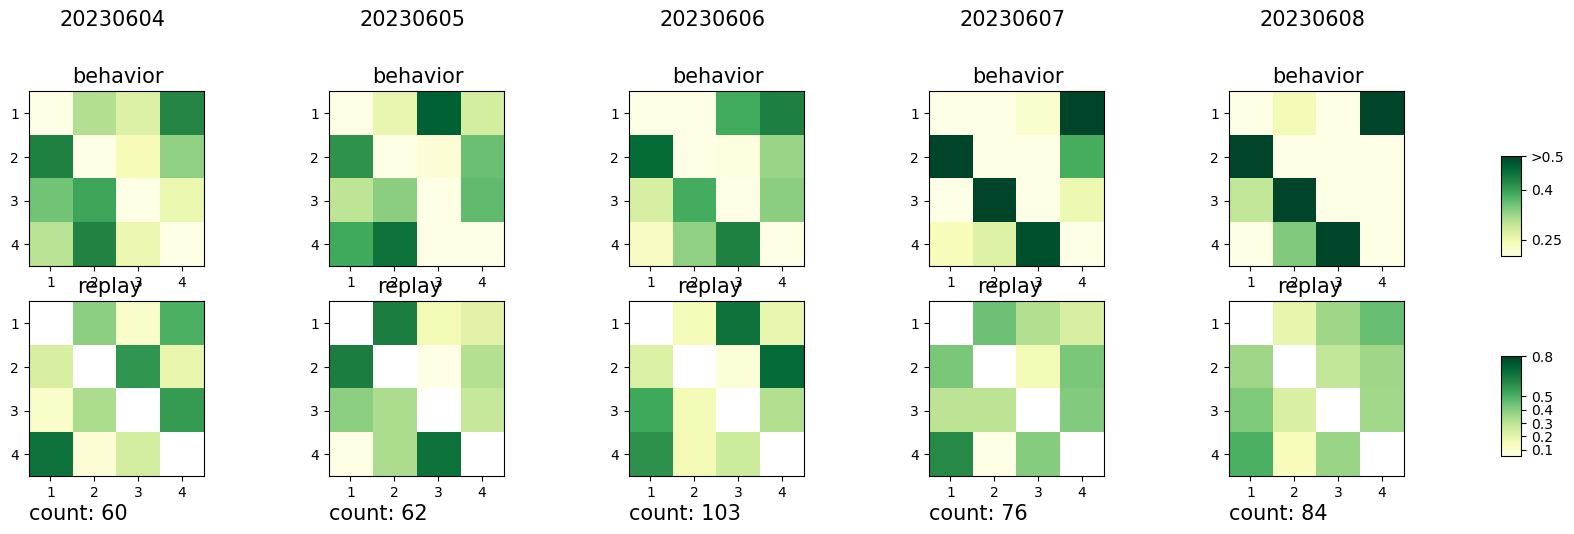

In [22]:
version = 1
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 0.8
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = P_behavior_all[d]
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0.2, vmax = 0.5, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0.05, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)

    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.5,-0.7,'behavior',fontsize = 15)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, 0.5])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>0.5'])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', str(REPLAY_VMAX)])  # vertically oriented colorbar

#### seperate by fragmented length

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.9, '0.9')]

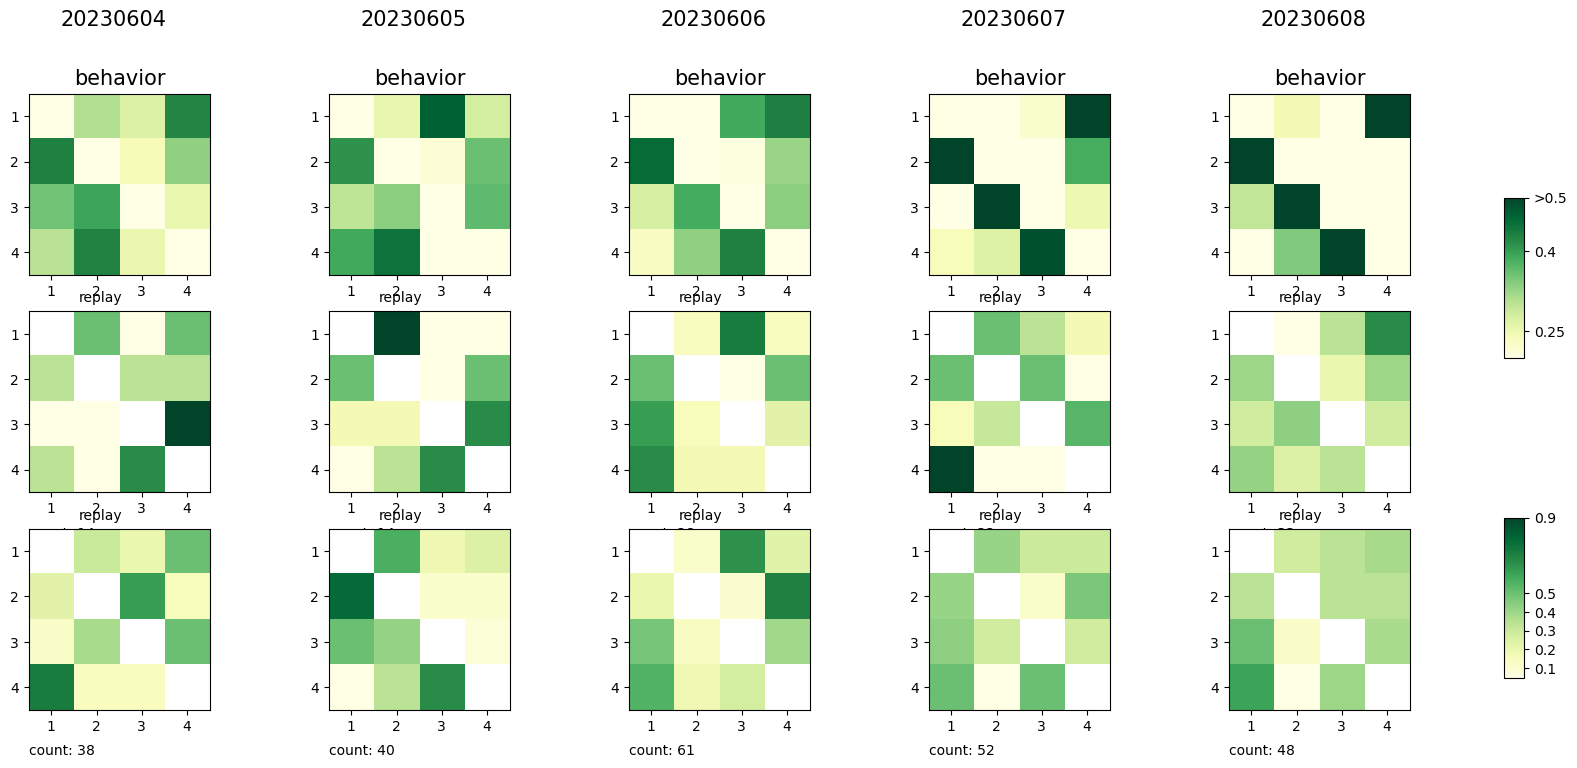

In [23]:
version = 1
fig,axes = plt.subplots(3,len(dates_to_plot),figsize = (20,8))

REPLAY_VMAX = 0.9
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = P_behavior_all[d]
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0.2, vmax = 0.5, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all_frag[d][version]
    replay_count = 'count: ' + str(int(count_all_frag[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0.05, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 10)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 10)

    replay_data = P_replay_all_cont[d][version]
    replay_count = 'count: ' + str(int(count_all_cont[d]))
    im2 = axes[2,d_ind].imshow(replay_data, vmin = 0.05, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[2,d_ind].text(0.6,-0.7,'replay',fontsize = 10)
    axes[2,d_ind].text(-0.5,4.5,replay_count,fontsize = 10)

    
    # label arms
    for ai in [0,1,2]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.5,-0.7,'behavior',fontsize = 15)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, 0.5])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>0.5'])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', str(REPLAY_VMAX)])  # vertically oriented colorbar

#### 2. Count

#### without seperating by the fragmented length

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 21.0, '>21.0')]

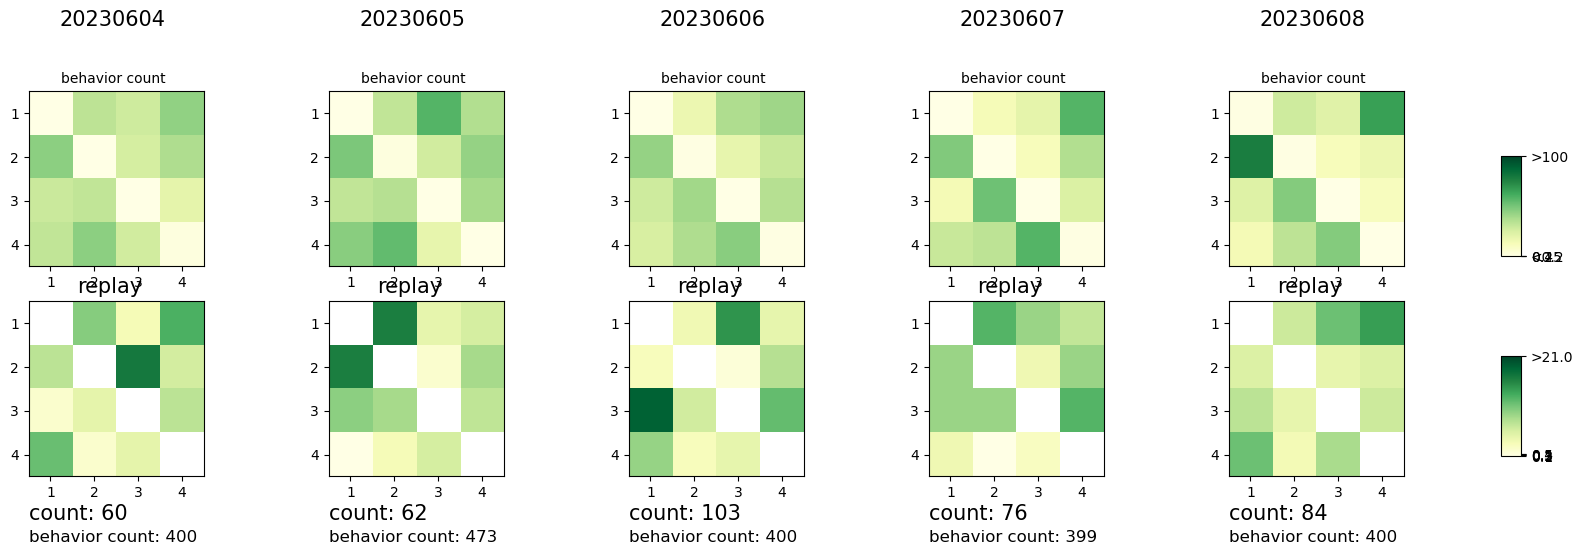

In [24]:
version = 0
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

#REPLAY_VMAX = 25 #25
BEHAVIOR_VMAX = 100 #100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    REPLAY_VMAX =  count[d] / 4
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)

    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.25,-0.7,'behavior count',fontsize = 10)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### seperate by fragmented length

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 12.0, '>12.0')]

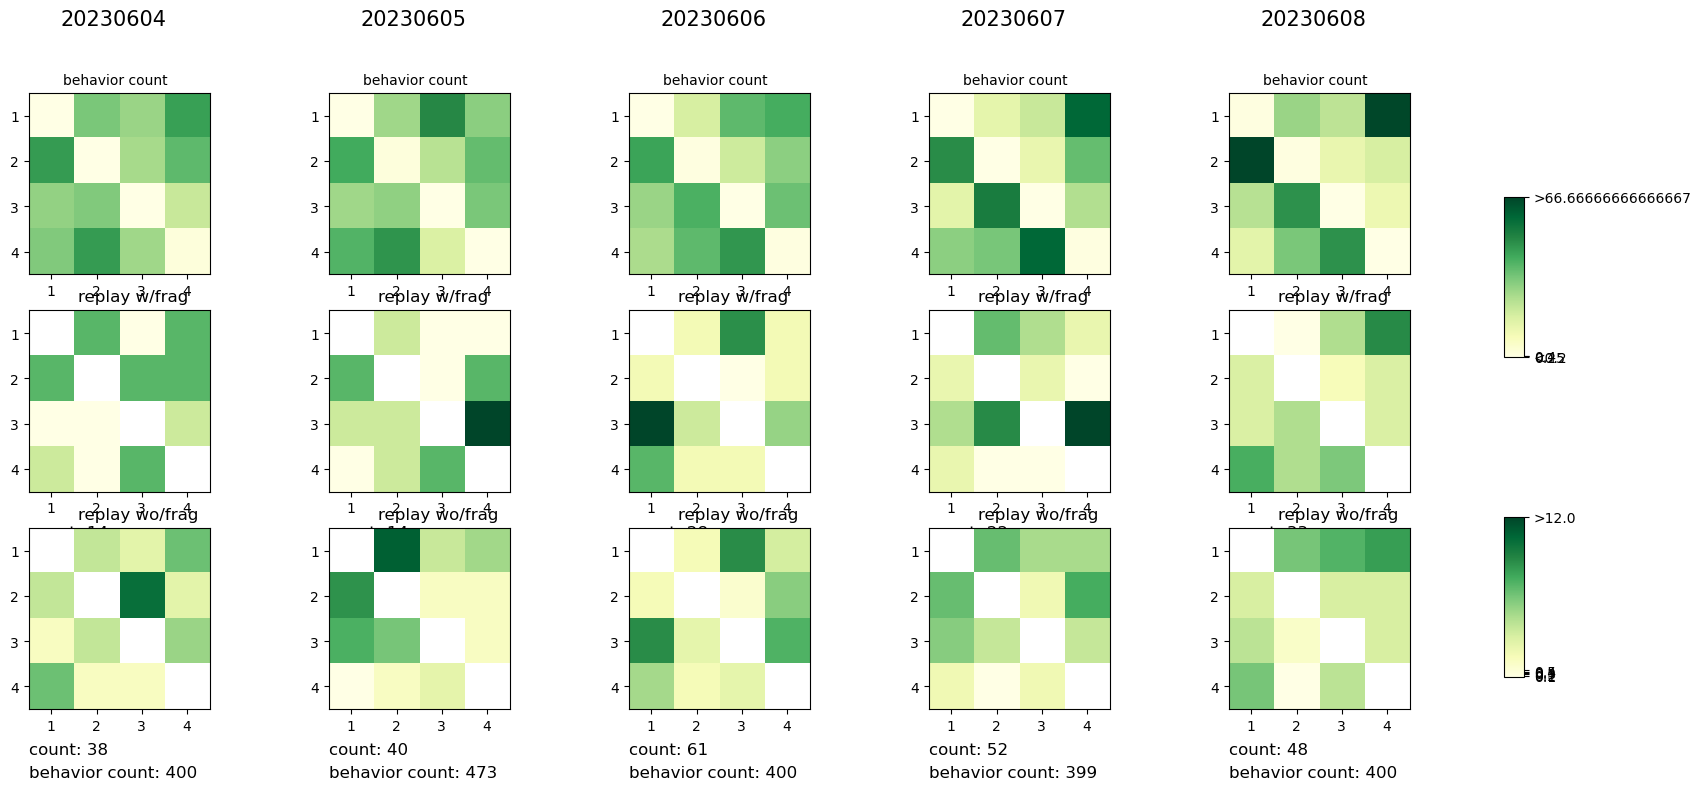

In [25]:
version = 0
fig,axes = plt.subplots(3,len(dates_to_plot),figsize = (20,8))


BEHAVIOR_VMAX = 100 #100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    BEHAVIOR_VMAX = np.sum(behavior_data)/6 #100 #0.25
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all_frag[d][version]
    replay_count = 'count: ' + str(int(count_all_frag[d]))
    REPLAY_VMAX =  count_all_frag[d] / 4
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay w/frag',fontsize = 12)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 12)

    replay_data = P_replay_all_cont[d][version]
    replay_count = 'count: ' + str(int(count_all_cont[d]))
    REPLAY_VMAX = count_all_cont[d] / 4
    im2 = axes[2,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[2,d_ind].text(0.6,-0.7,'replay wo/frag',fontsize = 12)
    axes[2,d_ind].text(-0.5,4.5,replay_count,fontsize = 12)


    
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[2,d_ind].text(-0.5,5,behavior_count,fontsize = 12)


    
    # label arms
    for ai in [0,1,2]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.25,-0.7,'behavior count',fontsize = 10)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar

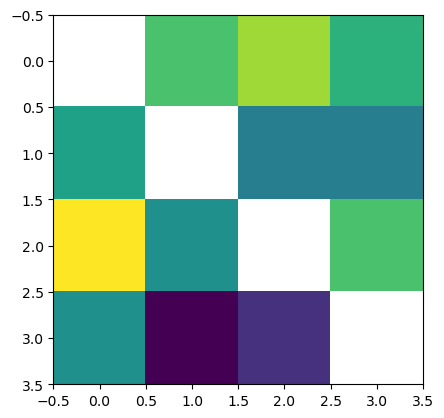

In [17]:
plt.imshow(P_replay_all_cont['20230604'][0] + P_replay_all_cont['20230605'][0] + P_replay_all_cont['20230606'][0])

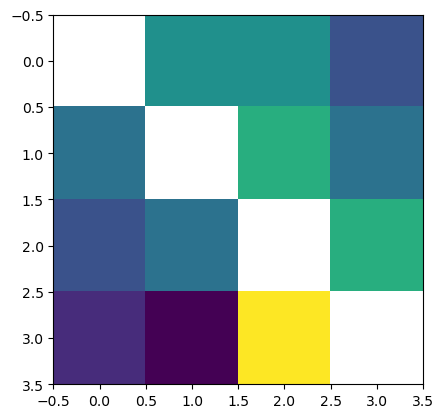

In [132]:
plt.imshow(P_replay_all_frag['20221018'][0] + P_replay_all_frag['20221019'][0])

#### 3. Rewarded Transition Behavior Count

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 15.0, '>15')]

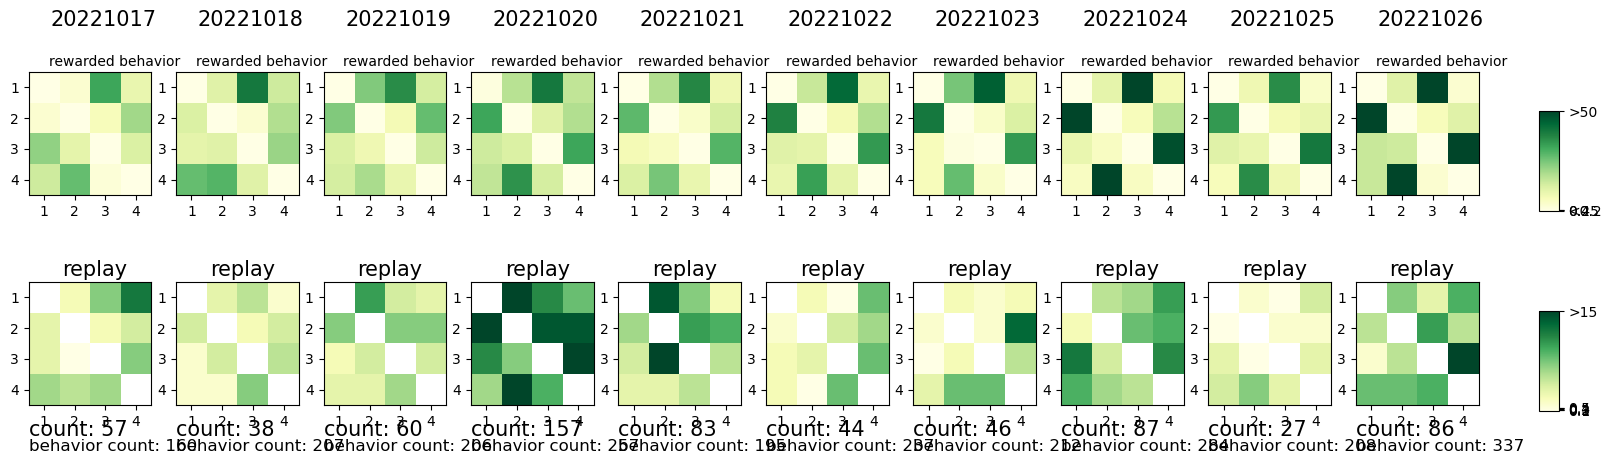

In [119]:
version = 0
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 15 #25
BEHAVIOR_VMAX = 50 #100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_reward_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)
    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.15,-0.7,'rewarded behavior',fontsize = 10)


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


### seperated by fragmented

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 10.0, '>10')]

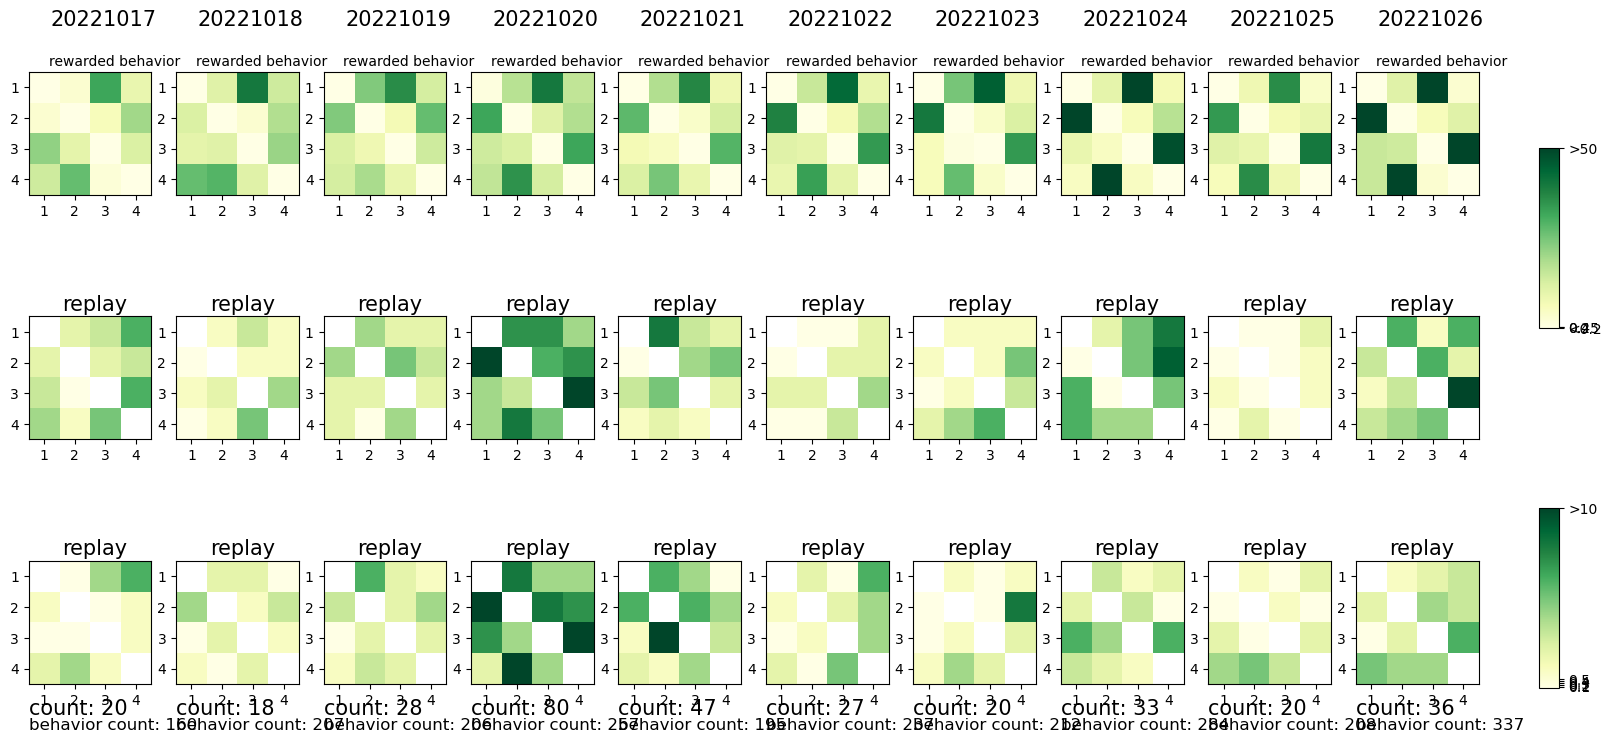

In [122]:
version = 0
fig,axes = plt.subplots(3,len(dates_to_plot),figsize = (20,9))

REPLAY_VMAX = 10 #25
BEHAVIOR_VMAX = 50 #100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_reward_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all_frag[d][version]
    replay_count = 'count: ' + str(int(count_all_frag[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)

    replay_data = P_replay_all_cont[d][version]
    replay_count = 'count: ' + str(int(count_all_cont[d]))
    im2 = axes[2,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[2,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    
    axes[2,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[2,d_ind].text(-0.5,5,behavior_count,fontsize = 12)
    
    # label arms
    for ai in [0,1,2]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.15,-0.7,'rewarded behavior',fontsize = 10)


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 4. delta reward

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '>0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.3, '>0.3')]

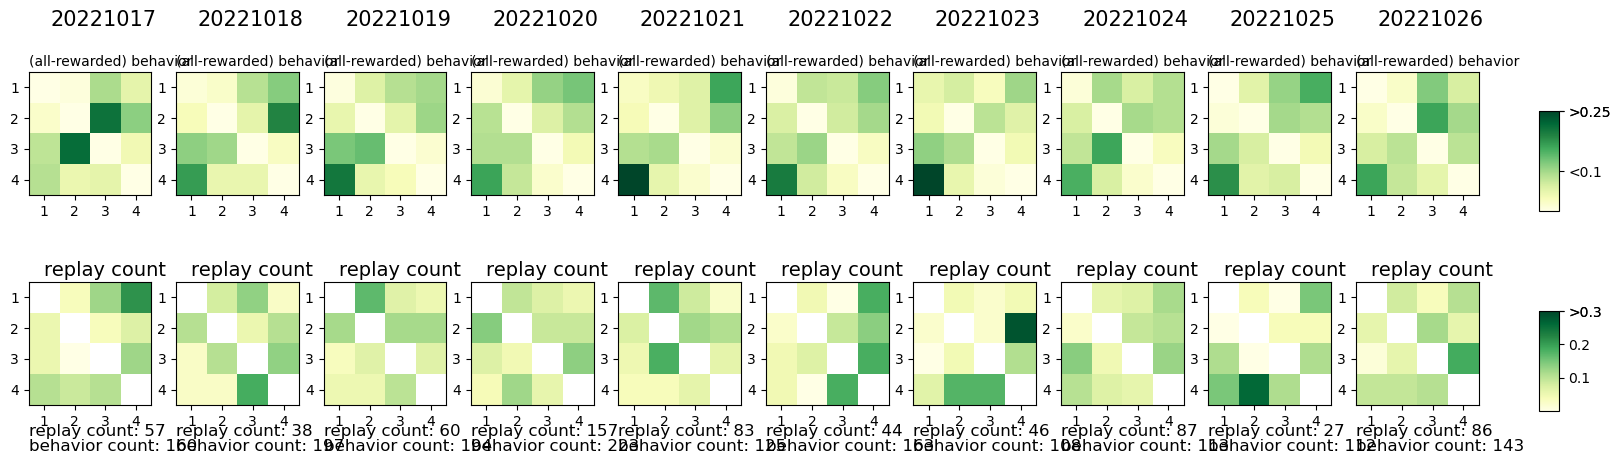

In [124]:
version = 0
normalize = 1
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

if normalize:
    REPLAY_VMAX = 0.3
    BEHAVIOR_VMAX = 0.25
else:
    REPLAY_VMAX = 20
    BEHAVIOR_VMAX = 40 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    d_minus1 = dates_to_plot[d_ind-1]
    behavior_data = (C_behavior_all[d]-C_behavior_reward_all[d])#/np.sum(C_behavior_all[d])
    if normalize:
        behavior_data_plot = behavior_data/np.sum(behavior_data)
        im1 = axes[0,d_ind].imshow(behavior_data_plot, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')
    else:
        im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'replay count: ' + str(int(count[d]))
    if normalize:
        replay_data = replay_data/np.nansum(replay_data)
        im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    else:
        im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0,-0.7,'replay count',fontsize = 14)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 12)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)
    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(-0.5,-0.7,'(all-rewarded) behavior',fontsize = 10)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.1', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 5. Trial-by-trial analysis

In [28]:
from spyglass.shijiegu.pairwiseDecode import trial_by_trial_behavior_replay_pairs,trial_by_trial_random_behavior_replay_pairs

LOOK_BACK_NUM = 2
(p_replay_reward, count_reward, 
 p_transition_reward, count_transition_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST_REWARD')
(p_replay_reward_reward, count_reward_reward,
 p_transition_reward_reward, count_transition_reward_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','REWARD_REWARD')
(p_replay_nonreward, count_nonreward,
 p_transition_nonreward, count_transition_nonreward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','NONREWARD')
(p_replay_all, count_all,
 p_transition_all, count_transition_all) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST')
(p_replay_fu, count_fu,
 p_transition_fu, count_transition_fu) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'normal','FUTURE')

(p_replay_reward_r, count_reward_r,
  p_transition_reward_r, count_transition_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST_REWARD')
(p_replay_reward_reward_r, count_reward_reward_r,
 p_transition_reward_reward_r, count_transition_reward_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','REWARD_REWARD')
(p_replay_nonreward_r, count_nonreward_r,
 p_transition_nonreward_r, count_transition_nonreward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','NONREWARD')
(p_replay_all_r, count_all_r,
 p_transition_all_r, count_transition_all_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST')
(p_replay_fu_r, count_fu_r,
 p_transition_fu_r, count_transition_fu_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','FUTURE')

KeyboardInterrupt: 

In [54]:
LOOK_BACK_NUM = 2
(p_replay_random_mean, p_replay_random_25, p_replay_random_975,
            p_transition_random_mean, p_transition_random_25, p_transition_random_975) = trial_by_trial_random_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','RANDOM')

working on bootstrap iteration: 0
working on bootstrap iteration: 1
working on bootstrap iteration: 2
working on bootstrap iteration: 3
working on bootstrap iteration: 4
working on bootstrap iteration: 5
working on bootstrap iteration: 6
working on bootstrap iteration: 7
working on bootstrap iteration: 8
working on bootstrap iteration: 9
working on bootstrap iteration: 10
working on bootstrap iteration: 11
working on bootstrap iteration: 12
working on bootstrap iteration: 13
working on bootstrap iteration: 14
working on bootstrap iteration: 15
working on bootstrap iteration: 16
working on bootstrap iteration: 17
working on bootstrap iteration: 18
working on bootstrap iteration: 19
working on bootstrap iteration: 20
working on bootstrap iteration: 21
working on bootstrap iteration: 22
working on bootstrap iteration: 23
working on bootstrap iteration: 24
working on bootstrap iteration: 25
working on bootstrap iteration: 26
working on bootstrap iteration: 27
working on bootstrap iteration

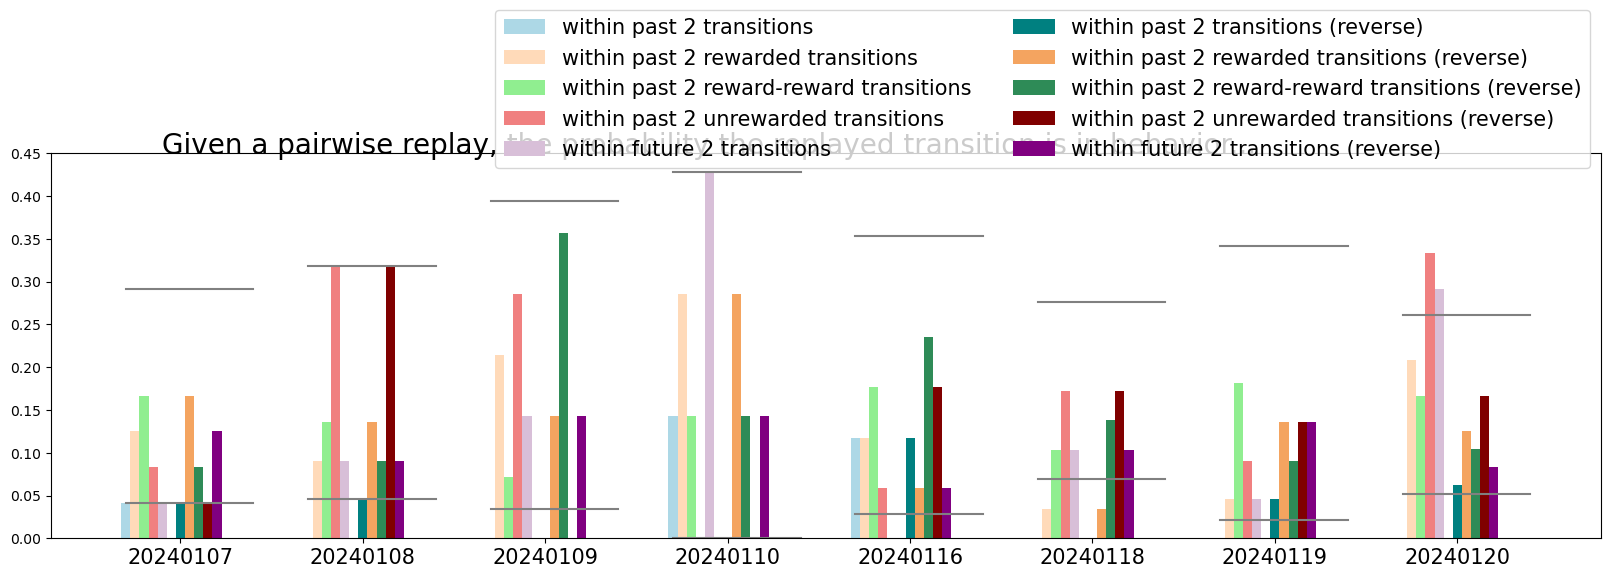

In [55]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.05
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_replay_random_25[d],p_replay_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_replay_random_975[d],p_replay_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)


"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.45,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.4))

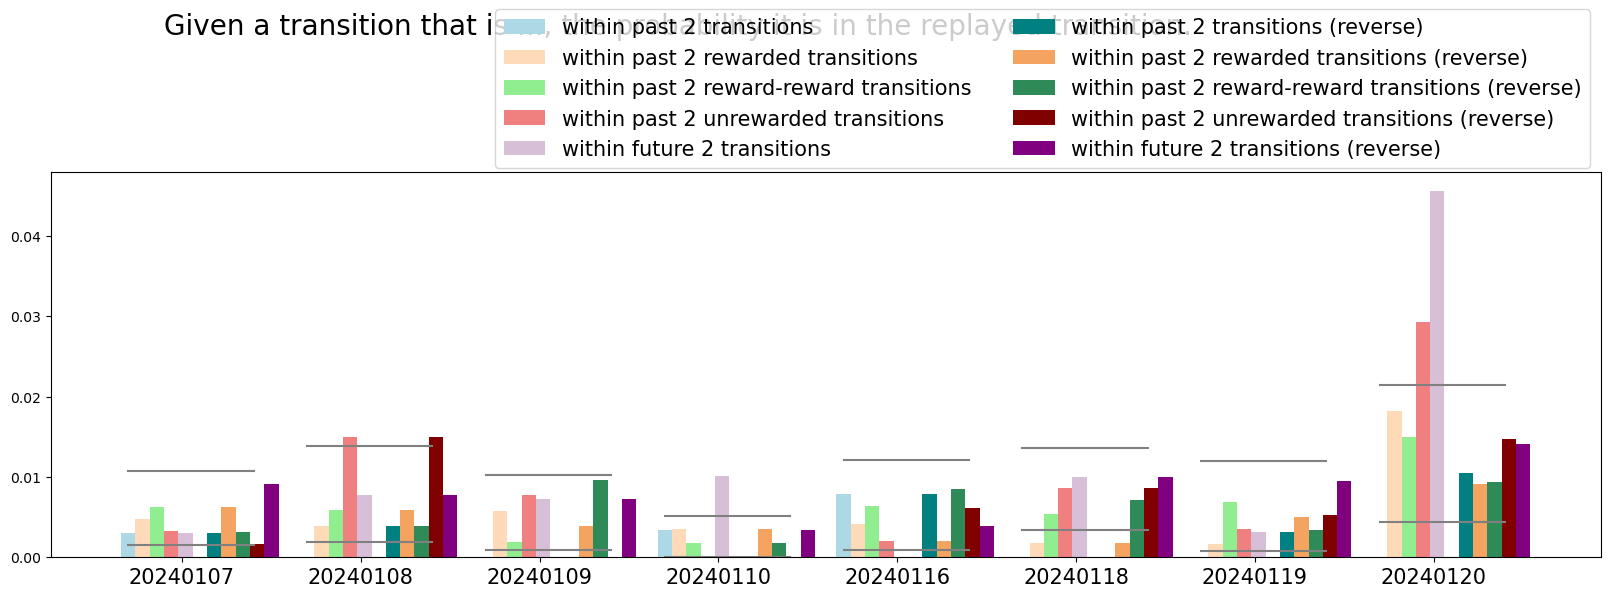

In [56]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.08
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_transition_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_transition_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_transition_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_transition_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_transition_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_transition_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_transition_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_transition_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_transition_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_transition_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_transition_random_25[d],p_transition_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_transition_random_975[d],p_transition_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)


"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_transition_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_transition_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_transition_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_transition_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_transition_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_transition_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_transition_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_transition_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_transition_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_transition_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.065,'Given a transition that is ..., the probability it is in the replayed transition.',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.45))

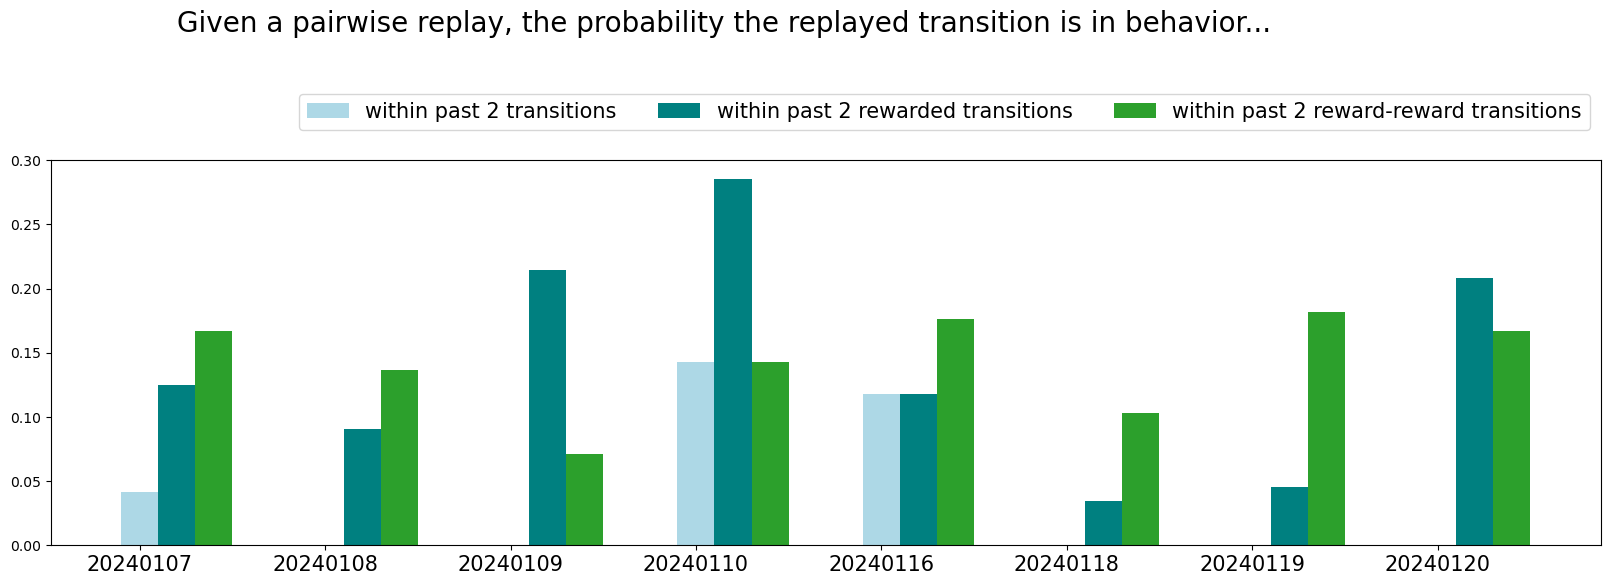

In [57]:
### In the case of just wanting one set
fig,axes = plt.subplots(1,1,figsize = (20,5))
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = 0.2,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+0.2,p_replay_reward[d],color = 'teal',width = 0.2,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+0.4,p_replay_reward_reward[d],color = 'C2',width = 0.2,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = 0.2)
        axes.bar(i+0.2,p_replay_reward[d],color = 'teal',width = 0.2)
        axes.bar(i+0.4,p_replay_reward_reward[d],color = 'C2',width = 0.2)
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot)))
axes.set_xticklabels(dates_to_plot,fontsize = 15)
axes.text(0.2,axes.get_ylim()[1] + 0.1,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);

In [878]:
LOOK_BACK_NUM = 1
(p_replay_reward, count_reward, 
 p_transition_reward, count_transition_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST_REWARD')
(p_replay_reward_reward, count_reward_reward,
 p_transition_reward_reward, count_transition_reward_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','REWARD_REWARD')
(p_replay_nonreward, count_nonreward,
 p_transition_nonreward, count_transition_nonreward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','NONREWARD')
(p_replay_all, count_all,
 p_transition_all, count_transition_all) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST')
(p_replay_fu, count_fu,
 p_transition_fu, count_transition_fu) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'normal','FUTURE')

(p_replay_reward_r, count_reward_r,
  p_transition_reward_r, count_transition_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST_REWARD')
(p_replay_reward_reward_r, count_reward_reward_r,
 p_transition_reward_reward_r, count_transition_reward_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','REWARD_REWARD')
(p_replay_nonreward_r, count_nonreward_r,
 p_transition_nonreward_r, count_transition_nonreward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','NONREWARD')
(p_replay_all_r, count_all_r,
 p_transition_all_r, count_transition_all_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST')
(p_replay_fu_r, count_fu_r,
 p_transition_fu_r, count_transition_fu_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','FUTURE')

In [879]:
LOOK_BACK_NUM = 1
(p_replay_random_mean, p_replay_random_25, p_replay_random_975,
            p_transition_random_mean, p_transition_random_25, p_transition_random_975) = trial_by_trial_random_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','RANDOM')

working on bootstrap iteration: 0
working on bootstrap iteration: 1
working on bootstrap iteration: 2
working on bootstrap iteration: 3
working on bootstrap iteration: 4
working on bootstrap iteration: 5
working on bootstrap iteration: 6
working on bootstrap iteration: 7
working on bootstrap iteration: 8
working on bootstrap iteration: 9
working on bootstrap iteration: 10
working on bootstrap iteration: 11
working on bootstrap iteration: 12
working on bootstrap iteration: 13
working on bootstrap iteration: 14
working on bootstrap iteration: 15
working on bootstrap iteration: 16
working on bootstrap iteration: 17
working on bootstrap iteration: 18
working on bootstrap iteration: 19
working on bootstrap iteration: 20
working on bootstrap iteration: 21
working on bootstrap iteration: 22
working on bootstrap iteration: 23
working on bootstrap iteration: 24
working on bootstrap iteration: 25
working on bootstrap iteration: 26
working on bootstrap iteration: 27
working on bootstrap iteration

In [877]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/pairwiseDecode.py(324)trial_by_trial_behavior_replay_pairs_day()
    322         denominator_transition += denominator_transition_
    323     return (nominator_replay/denominator_replay,denominator_replay,
--> 324             nominator_transition/denominator_transition,denominator_transition)
    325 
    326 



ipdb>  nominator_transition


0


ipdb>  exit


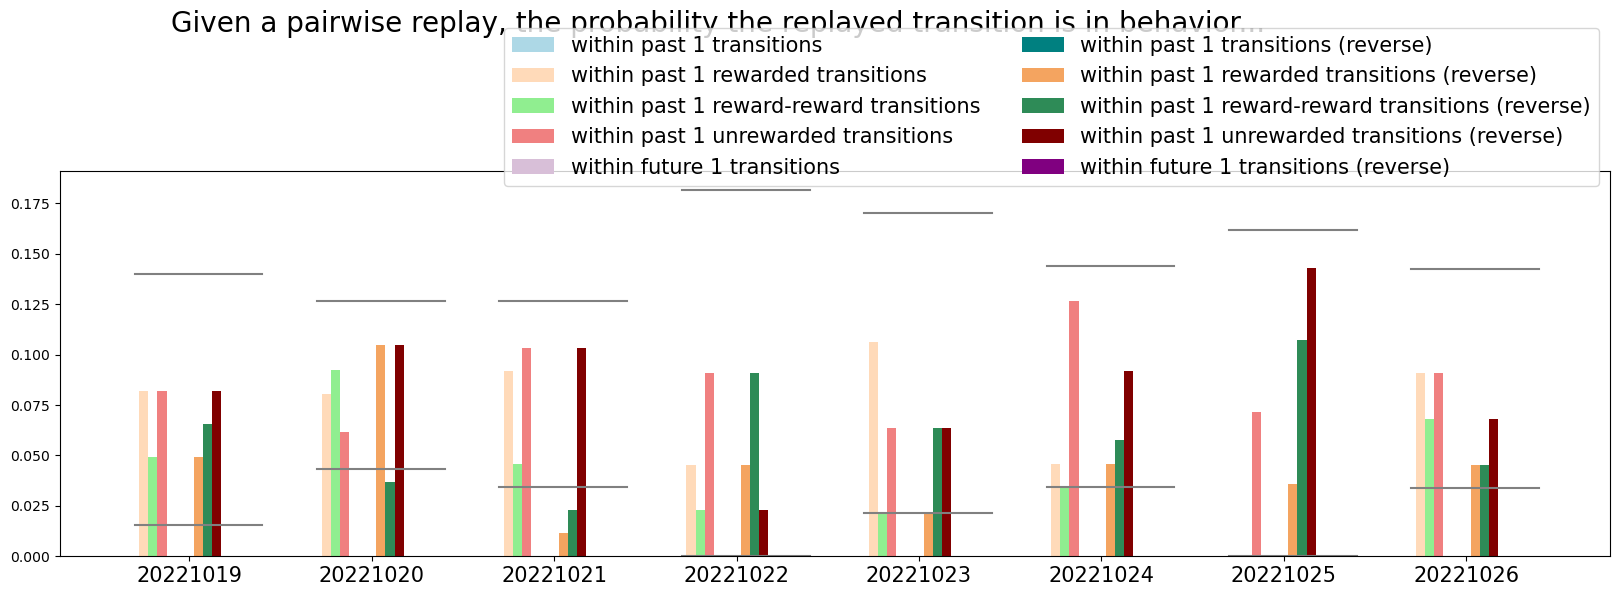

In [885]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.05
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_replay_random_25[d],p_replay_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_replay_random_975[d],p_replay_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)

"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.26,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.4))

### Plot 1b. Find intersection events

In [256]:
key_acausal = {'nwb_file_name': 'eliot20221023_.nwb',
        'interval_list_name': '02_Seq2Session1',
        'classifier_param_name':'default_decoding_gpu_4armMaze',
        'encoding_set':encoding_set}
key_causal = key_acausal.copy()
key_causal['classifier_param_name'] = 'causal_decoding_gpu_4armMaze'

trials_a = pd.DataFrame((TrialChoiceReplayTransition & key_acausal).fetch1('choice_reward_replay_transition'))
trials_c = pd.DataFrame((TrialChoiceReplayTransition & key_causal).fetch1('choice_reward_replay_transition'))

In [274]:
transition_session = np.zeros((4,4))

for t in [60]:#trials_a.index:
    r_a = set(trials_a.loc[t].replayed_transitions)
    r_c = set(trials_c.loc[t].replayed_transitions)
    common_t = r_a.intersection(r_c)
    for ct in common_t:
        i = int(ct[0])-1
        j = int(ct[1])-1
        transition_session[i,j] += 1

In [275]:
common_t

set()

In [261]:
transition_session

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [2., 1., 1., 0.]])

In [121]:
trials_c.loc[18].replayed_transitions

[]

In [133]:
a = set([(2,4),(1,3)])
b = set([(2,4),(1,3)])

In [135]:
c = a.intersection(b)

In [136]:
c

{(1, 3), (2, 4)}

### Plot 2. Correlation with the sequence

In [48]:
version = 2
transition_dict = {}
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    transition_dict[d] = P_replay_all[d][version]
    
xcorr_replay_plot= findXCorrAllDays(transition_dict)

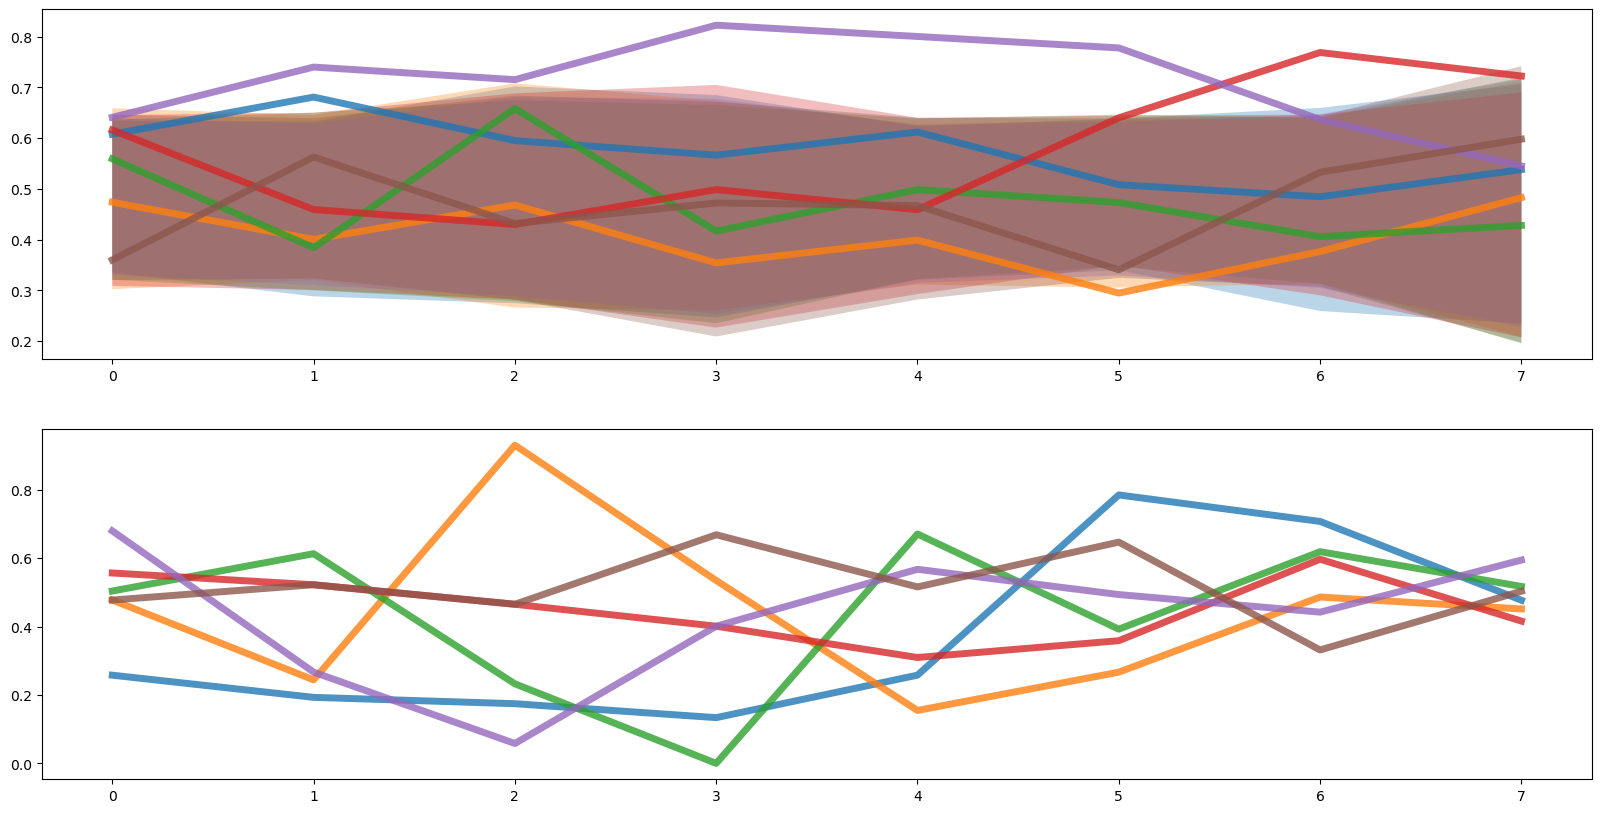

In [49]:
f,axes = plt.subplots(2,1,figsize = (20,10))
for seq_ind in range(6):
    axes[0].plot(xcorr_plot[:,seq_ind],'C'+str(seq_ind),linewidth = 5,alpha=0.8)
    axes[0].fill_between(np.arange(len(dates_to_plot)),
                    xcorr25_plot[:,seq_ind],
                    xcorr975_plot[:,seq_ind], facecolor='C'+str(seq_ind), alpha=0.3)

for seq_ind in range(6):
    axes[1].plot(xcorr_replay_plot[:,seq_ind],'C'+str(seq_ind),linewidth = 5,alpha=0.8)

### Investigate another session

In [224]:
session_interval

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']

In [48]:
key = {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': '04_Seq2Session2'}
T_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'choice_reward_replay_transition'))
matrix_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'transitions'))

In [49]:
T_transition_[:40]

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,rewardNum,ripple_H,ripple_O,replay_H,replay_O,ripple_ID_H,ripple_ID_O,current,future_H,future_O,past,past_reward
1,1.666468e+09,1.0,1.666468e+09,2.0,[],1.0,[],"[[[1666467957.1042895, 1666467957.1802895], [1...",[],"[[[4], [4], [2]]]",[],[1],2.0,2.0,4.0,NaN,NaN
2,1.666468e+09,1.0,1.666468e+09,4.0,[],1.0,[],"[[[1666467971.4162765, 1666467971.910276]]]",[],[[[4]]],[],[2],4.0,4.0,3.0,2.0,NaN
3,1.666468e+09,1.0,1.666468e+09,3.0,"[(1, 3)]",2.0,"[[[1666467986.9242623, 1666467987.114262], [16...",[],"[[[0, 3], [0]], [[0]], [[1], [3]]]",[],"[3, 4, 5]",[],3.0,3.0,1.0,4.0,NaN
4,1.666468e+09,1.0,1.666468e+09,1.0,[],1.0,"[[[1666468033.5662196, 1666468033.8102193]]]",[],[[[0]]],[],[6],[],1.0,1.0,4.0,3.0,3.0
5,1.666468e+09,1.0,1.666468e+09,4.0,[],2.0,"[[[1666468058.1321971, 1666468058.2501972], [1...","[[[1666468074.1761825, 1666468074.3281825], [1...","[[[0], [2], [], []], [[0], [3], []]]","[[[4], [], []], [[], [0]], [[3, 4]], [[4]]]","[7, 8]","[9, 10, 11, 12]",4.0,4.0,2.0,1.0,3.0
6,1.666468e+09,1.0,1.666468e+09,2.0,[],2.0,"[[[1666468091.9001665, 1666468092.0261662], [1...","[[[1666468100.436159, 1666468100.7301583]], [[...","[[[0], [0]], [[], []]]","[[[2]], [[2, 3], [3], [2]], [[2]], [[2], [2]]]","[13, 14]","[15, 16, 17, 18]",2.0,2.0,3.0,4.0,4.0
7,1.666468e+09,1.0,1.666468e+09,3.0,[],1.0,"[[[1666468129.8861315, 1666468130.0101316], [1...",[],"[[[], [], [], [0]], [[], [0]]]",[],"[19, 20]",[],3.0,3.0,1.0,2.0,2.0
8,1.666468e+09,1.0,1.666468e+09,1.0,[],2.0,"[[[1666468148.7041144, 1666468148.9621143], [1...","[[[1666468162.6301017, 1666468162.7521017], [1...","[[[0, 3], [], [0]]]","[[[], [], [], [0]]]",[21],[22],1.0,1.0,4.0,3.0,2.0
9,1.666468e+09,1.0,1.666468e+09,4.0,[],1.0,"[[[1666468180.2980857, 1666468180.5160854], [1...",[],"[[[0], [0]], [[0, 2], [], [0], [], [0]], [[0]]...",[],"[23, 24, 25, 26, 27]",[],4.0,4.0,2.0,1.0,1.0
10,1.666468e+09,1.0,1.666468e+09,2.0,[],1.0,"[[[1666468201.668066, 1666468201.784066], [166...",[],"[[[], [], [0]]]",[],[28],[],2.0,2.0,1.0,4.0,1.0


In [227]:
matrix_transition_ 

,0,1,2,3
0,7.0,0.0,0.0,1.0
1,0.0,3.0,0.0,2.0
2,0.0,2.0,7.0,0.0
3,0.0,9.0,2.0,17.0
